In [1]:
# import libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import ReLU
import numpy as np

from ipynb.fs.full.models import make_vgg16, make_nn
import pandas as pd
from sklearn import preprocessing
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Load Data

In [3]:
# import data
suff = '_8.29'
cols = ['wpop_diff', 'bpop_diff', 'area_diff', 'perim_diff','label', 'image_file']
over_cols = ['wpop_diff', 'bpop_diff', 'area_diff', 'image_file', 'label']

demo_train_df = pd.read_csv(f'Outputs/statewide_train_data{suff}.csv', header=0, names=cols)
demo_test_df = pd.read_csv(f'Outputs/statewide_test_data{suff}.csv', header=0, names=cols)
demo_val_df = pd.read_csv(f'Outputs/statewide_val_data{suff}.csv', header=0, names=cols)

over_demo_train_df = pd.read_csv('Outputs/statewide_train_data_oversample.csv', header=0, names=over_cols)
over_demo_test_df = pd.read_csv('Outputs/statewide_test_data_oversample.csv', header=0, names=over_cols)
over_demo_val_df = pd.read_csv('Outputs/statewide_val_data_oversample.csv', header=0, names=over_cols)

### Helper Functions

In [ ]:
def gen_report(fit_model, test_data, test_labels, title):
    """
    Generates confusion matrix and classification report for given model on provided test data.

    Paramters: 
        fit_model: Keras.model - compiled Keras model
        test_data: np.array, pd.Dataframe column, list - X input for test data
        test_labels: np.array, pd.Dataframe column, list - y input for test data (labels)
        title: str - title of confusion matrix

    return: 
        None - generates the confusion matrix that can then be saved and prints the classification report 
    """
    # make model predictions on test data
    preds = fit_model.predict(test_data)

    # get Boolean label from continuous prediction confidence score
    pred_labels = [False if x < 0.5 else True for x in preds]

    # generate and show confusion matrix
    conf = confusion_matrix(test_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # print classification report
    print(classification_report(test_labels, pred_labels))

In [4]:
def normalize(df, cols):
    """
    Min-max normalizes provided columns within dataframe.

    Paramters: 
        df: pd.Dataframe - dataframe with columns to normalize
        cols: list - list of column names as strings to normalize

    return: 
        None - Normalizes the provided columns in df in place
    """
    x = df[cols].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df[cols] = x_scaled

In [ ]:
def img_array(df_image_col, subset=None, resize=True):
    """
    Converts images to np.array format for use in Keras models.

    Paramters: 
        df_image_col: pd.Dataframe column, list - column in dataframe with image file names as strings
        subset: str - subset that the data belongs to. One of three options: 'train', 'test', 'val'
        resize: Boolean - whether the images have been preprocessed/resized. Default=False

    return: 
        ret_arr: np.array - numerical representation of images in single array
    """
    # initialize return array
    ret_arr = []

    # loop through image file names
    for i in df_image_col:

        # read and append image to return array
        if resize:
            im = cv2.imread(f'Outputs/images/statewide/{subset}/processed/' + i)
        
        else:
            im = cv2.imread('Outputs/images/statewide/' + i)
        
        ret_arr.append(im)
        
    return np.array(ret_arr, dtype=object)

### Final Data Preparation

In [5]:
# normalize numerical features
normal = True

if normal:
    df_list = [demo_test_df, demo_train_df, demo_val_df] #, over_demo_test_df, over_demo_train_df, over_demo_val_df]
    norm_cols = ['wpop_diff', 'bpop_diff', 'area_diff', 'perim_diff']
    for data in df_list:
        normalize(data, norm_cols)

In [6]:
demo_train_df

,wpop_diff,bpop_diff,area_diff,perim_diff,label,image_file
711,0.652815,0.611372,0.551100,0.396517,False,state_plot7120.png
98,0.283966,0.323942,0.554893,0.539535,False,state_plot990.png
937,0.418857,0.325763,0.623737,0.436361,True,state_plot9380.png
357,0.505302,0.466818,0.725118,0.359819,False,state_plot3580.png
701,0.279588,0.372019,0.841260,0.178652,True,state_plot7020.png
...,...,...,...,...,...,...
700,0.422763,0.449401,0.842477,0.157667,False,state_plot7010.png
178,0.555319,0.616850,0.345580,0.110396,True,state_plot1790.png
299,0.284044,0.333282,0.412128,0.165183,True,state_plot3000.png
408,0.205654,0.133490,0.301037,0.579995,True,state_plot4090.png


In [8]:
# create image arrays for train/test/val sets

# normal, unbalanced data
train_images = img_array(demo_train_df['image_file'], resize=False)
test_images = img_array(demo_test_df['image_file'], resize=False)
val_images = img_array(demo_val_df['image_file'], resize=False)

# oversampled data
over_train_images = img_array(over_demo_train_df['image_file'], resize=False)
over_test_images = img_array(over_demo_test_df['image_file'], resize=False)
over_val_images = img_array(over_demo_val_df['image_file'], resize=False)

### Create Models

In [9]:
# make individual CNN and NN models with functions from models.ipynb
cnn = make_vgg16()
nn = make_nn(4)

# combine the model outputs
combined_model = tf.keras.layers.concatenate([nn.output, cnn.output],axis=1)

# final output layers
x = Dense(4, activation='relu')(combined_model)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[nn.input, cnn.input], outputs=x)


### Compile Model

In [10]:
opt = Adam(learning_rate=1e-3, epsilon=1e-3 / 200)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

### Fit, Train, and Test Model

In [11]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

##### Unbalanced Data Model

In [14]:
statewide_model = model.fit(
	x=[demo_train_df.iloc[:,:-2].values.astype(np.float32), train_images.astype(np.float32)], 
	y=demo_train_df['label'].values,
	validation_data=([demo_val_df.iloc[:,:-2].values.astype(np.float32), val_images.astype(np.float32)], demo_val_df['label'].values),
	callbacks=early,
	epochs=20,
	batch_size=32)

Epoch 1/20
23/23 [==============================] - 125s 5s/step - loss: 0.6935 - accuracy: 0.6194 - val_loss: 0.6901 - val_accuracy: 0.6000
Epoch 2/20
23/23 [==============================] - 126s 6s/step - loss: 0.6870 - accuracy: 0.6333 - val_loss: 0.6863 - val_accuracy: 0.6000
Epoch 3/20
23/23 [==============================] - 128s 6s/step - loss: 0.6780 - accuracy: 0.6333 - val_loss: 0.6802 - val_accuracy: 0.6000
Epoch 4/20
23/23 [==============================] - 125s 5s/step - loss: 0.6698 - accuracy: 0.6333 - val_loss: 0.6776 - val_accuracy: 0.6000
Epoch 00004: early stopping


In [15]:
# evaluate model
eval_results = model.evaluate(x=[demo_test_df.iloc[:,:-2].values.astype(np.float32), test_images.astype(np.float32)],
y=demo_test_df['label'].values)

eval_results

7/7 [==============================] - 29s 4s/step - loss: 0.6823 - accuracy: 0.5800


[0.6822792291641235, 0.5799999833106995]

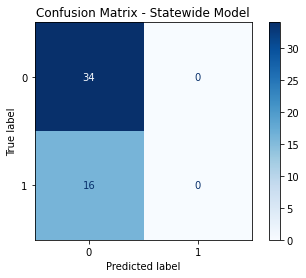

              precision    recall  f1-score   support

       False       0.68      1.00      0.81        34
        True       0.00      0.00      0.00        16

    accuracy                           0.68        50
   macro avg       0.34      0.50      0.40        50
weighted avg       0.46      0.68      0.55        50



c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
gen_report(model, 
[demo_test_df.iloc[:,:-2].values.astype(np.float32), test_images.astype(np.float32)],
demo_test_df['label'].values,
'Confusion Matrix - Statewide Model'
)

##### Oversampled Model

In [30]:
over_statewide_model = model.fit(
	x=[over_demo_train_df.iloc[:,:-2].values.astype(np.float32), over_train_images.astype(np.float32)], 
	y=over_demo_train_df['label'].values,
	validation_data=([over_demo_val_df.iloc[:,:-2].values.astype(np.float32), over_val_images.astype(np.float32)], over_demo_val_df['label'].values),
	callbacks=early,
	epochs=10,
	batch_size=32)

Epoch 1/10
17/17 [==============================] - 86s 5s/step - loss: 0.9262 - accuracy: 0.5077 - val_loss: 0.6932 - val_accuracy: 0.5345
Epoch 2/10
17/17 [==============================] - 85s 5s/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5172
Epoch 3/10
17/17 [==============================] - 86s 5s/step - loss: 0.6931 - accuracy: 0.4981 - val_loss: 0.6934 - val_accuracy: 0.5345
Epoch 4/10
17/17 [==============================] - 86s 5s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 00004: early stopping


In [31]:
# evaluate model
over_eval_results = model.evaluate(x=[over_demo_test_df.iloc[:,:-2].values.astype(np.float32), over_test_images.astype(np.float32)],
y=over_demo_test_df['label'].values)

over_eval_results

8/8 [==============================] - 35s 4s/step - loss: 0.6931 - accuracy: 0.5363


[0.6931073665618896, 0.5362903475761414]

### CNN Only Model

In [13]:
# image preprocessing - separate generators in case I want to test images different from train/validation images
data_generator = ImageDataGenerator(
    #width_shift_range=0.1,
    # shear_range=0.1,
    zoom_range=0.3,
    samplewise_center=True,
    samplewise_std_normalization=True
)

test_generator = ImageDataGenerator(
    # shear_range=0.1,
    zoom_range=0.3,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [14]:
# create train/test/val images with generators

img_dir = 'Outputs/images/statewide/'

data_train = data_generator.flow_from_directory(img_dir+'train/sub/', target_size=(224, 224), 
                            batch_size=32, class_mode='binary', 
                            shuffle=False,
                            save_to_dir=img_dir+'train/processed/',
                            # save_prefix='processed_'
                            )
data_val = data_generator.flow_from_directory(img_dir+'val/sub/', target_size=(224, 224), 
                            batch_size=32, class_mode='binary', 
                            shuffle=False,
                            save_to_dir=img_dir+'val/processed/',
                            # save_prefix='processed_'
                            )

data_test = test_generator.flow_from_directory(img_dir+'test/sub/', target_size=(224,224), 
                            batch_size=32, class_mode='binary',
                            shuffle=False,
                            save_to_dir=img_dir+'test/processed/',
                            # save_prefix='processed_'
                            )

Found 720 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [14]:
# same thing for oversampled data

over_train = data_generator.flow_from_directory(img_dir+'overs/train/', target_size=(224, 224), 
                            batch_size=16, class_mode='binary', 
                            # shuffle=True,
                            # save_to_dir=img_dir+'processed/',
                            # save_prefix='processed_'
                            )
over_val = data_generator.flow_from_directory(img_dir+'overs/val/', target_size=(224, 224), 
                            batch_size=16, class_mode='binary', 
                            # shuffle=True,
                            # save_to_dir=img_dir+'processed/',
                            # save_prefix='processed_'
                            )

over_test = test_generator.flow_from_directory(img_dir+'overs/test/', target_size=(224,224), 
                            batch_size=16, class_mode='binary',
                            # shuffle=True,
                            # save_to_dir=img_dir+'processed/',
                            # save_prefix='processed_'
                            )

Found 281 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [15]:
# build custom VGG16 CNN from scratch to allow for quick customization and tinkering

cnn_model = Sequential()
cnn_model.add(tf.keras.applications.VGG16(include_top=False, weights='imagenet', pooling='avg'))

for layer in cnn_model.layers:
    layer.trainable = False


cnn_model.add(Flatten())

cnn_model.add(Dense(4096, activation='relu'))

cnn_model.add(Dense(4096, activation='relu'))

cnn_model.add(Dense(1000, activation='relu'))

cnn_model.add(Dense(500, activation='relu'))
cnn_model.add(Dense(100, activation='relu'))

cnn_model.add(Dense(10, activation='relu'))

cnn_model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=1e-3, epsilon=1e-3 / 200)
cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# fit CNN model
cnn_model.fit(data_train, 
validation_data=data_val,
callbacks=early,
epochs=20,
batch_size=16)

Epoch 1/20
12/12 [==============================] - 16s 1s/step - loss: 0.7229 - accuracy: 0.8222 - val_loss: 0.6996 - val_accuracy: 0.7000
Epoch 2/20
12/12 [==============================] - 15s 1s/step - loss: 0.5011 - accuracy: 0.8222 - val_loss: 0.7203 - val_accuracy: 0.7000
Epoch 3/20
12/12 [==============================] - 16s 1s/step - loss: 0.4955 - accuracy: 0.8222 - val_loss: 0.6196 - val_accuracy: 0.7000
Epoch 4/20
12/12 [==============================] - 15s 1s/step - loss: 0.4871 - accuracy: 0.8222 - val_loss: 0.7942 - val_accuracy: 0.7000
Epoch 00004: early stopping


In [13]:
# evaluate CNN model
eval_results = cnn_model.evaluate(x=data_test, batch_size=16)

eval_results

4/4 [==============================] - 4s 812ms/step - loss: 0.8091 - accuracy: 0.6800


[0.8090676665306091, 0.6800000071525574]

##### Oversampled Data

In [17]:
cnn_model.fit(over_train, 
validation_data=over_val,
callbacks=early,
epochs=20,
batch_size=16)

Epoch 1/20
18/18 [==============================] - 24s 1s/step - loss: 0.7442 - accuracy: 0.5125 - val_loss: 0.7052 - val_accuracy: 0.3750
Epoch 2/20
18/18 [==============================] - 23s 1s/step - loss: 0.6929 - accuracy: 0.5018 - val_loss: 0.6935 - val_accuracy: 0.3750
Epoch 3/20
18/18 [==============================] - 22s 1s/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6934 - val_accuracy: 0.3750
Epoch 4/20
18/18 [==============================] - 22s 1s/step - loss: 0.6932 - accuracy: 0.5018 - val_loss: 0.6934 - val_accuracy: 0.3750
Epoch 00004: early stopping


In [18]:
eval_results = cnn_model.evaluate(x=over_test, batch_size=16)

eval_results

5/5 [==============================] - 5s 1s/step - loss: 0.6931 - accuracy: 0.5443


[0.6930528283119202, 0.5443037748336792]

### Preprocessing Statewide Images
    - Trying to see if tinkering with the statewide images will help the combined model like it did for the district models

In [19]:
# apply the transformations on the images

for i in range(len(data_val)):
    data_val.next()

for i in range(len(data_train)):
    data_train.next()

for i in range(len(data_test)):
    data_test.next()

In [20]:
# get original image file name
val_images = [file.split('\\')[1] for file in data_val.filenames]
test_images = [file.split('\\')[1] for file in data_test.filenames]
train_images = [file.split('\\')[1] for file in data_train.filenames]

In [21]:
demo_train_df.head()

,wpop_diff,bpop_diff,area_diff,perim_diff,label,image_file
711,0.652815,0.611372,0.551100,0.396517,False,state_plot7120.png
98,0.283966,0.323942,0.554893,0.539535,False,state_plot990.png
937,0.418857,0.325763,0.623737,0.436361,True,state_plot9380.png
357,0.505302,0.466818,0.725118,0.359819,False,state_plot3580.png
701,0.279588,0.372019,0.841260,0.178652,True,state_plot7020.png


In [22]:
# add column to dataframes for new processed image file names
demo_test_df['process_image'] = sorted(os.listdir(path=img_dir+'test/processed'), key=lambda x: int(str(x)[1:].split('_')[0]))
demo_train_df['process_image'] = sorted(os.listdir(path=img_dir+'train/processed'), key=lambda x: int(str(x)[1:].split('_')[0]))
demo_val_df['process_image'] = sorted(os.listdir(path=img_dir+'val/processed'), key=lambda x: int(str(x)[1:].split('_')[0]))

demo_train_df.head()

,wpop_diff,bpop_diff,area_diff,perim_diff,label,image_file,process_image
711,0.652815,0.611372,0.551100,0.396517,False,state_plot7120.png,_0_9082966.png
98,0.283966,0.323942,0.554893,0.539535,False,state_plot990.png,_1_5490020.png
937,0.418857,0.325763,0.623737,0.436361,True,state_plot9380.png,_2_6799282.png
357,0.505302,0.466818,0.725118,0.359819,False,state_plot3580.png,_3_2880876.png
701,0.279588,0.372019,0.841260,0.178652,True,state_plot7020.png,_4_7040159.png


In [23]:
# convert processed images to arrays
train_images_pross = img_array(demo_train_df['process_image'], subset='train',resize=True)
test_images_pross = img_array(demo_test_df['process_image'], subset='test',resize=True)
val_images_pross = img_array(demo_val_df['process_image'], subset='val',resize=True)

### Train, Test, and Fit Model with Preprocessed Images

In [25]:
pross_statewide_model = model.fit(
	x=[demo_train_df.iloc[:,:-3].values.astype(np.float32), train_images_pross.astype(np.float32)], 
	y=demo_train_df['label'].values,
	validation_data=([demo_val_df.iloc[:,:-3].values.astype(np.float32), val_images_pross.astype(np.float32)], demo_val_df['label'].values),
	callbacks=early,
	epochs=20,
	batch_size=32)

Epoch 1/20
23/23 [==============================] - 52s 2s/step - loss: 0.7462 - accuracy: 0.3667 - val_loss: 0.7160 - val_accuracy: 0.4000
Epoch 2/20
23/23 [==============================] - 51s 2s/step - loss: 0.7119 - accuracy: 0.3681 - val_loss: 0.7050 - val_accuracy: 0.3875
Epoch 3/20
23/23 [==============================] - 53s 2s/step - loss: 0.6995 - accuracy: 0.3958 - val_loss: 0.6964 - val_accuracy: 0.4875
Epoch 4/20
23/23 [==============================] - 50s 2s/step - loss: 0.6903 - accuracy: 0.5778 - val_loss: 0.6896 - val_accuracy: 0.5750
Epoch 5/20
23/23 [==============================] - 50s 2s/step - loss: 0.6832 - accuracy: 0.6250 - val_loss: 0.6855 - val_accuracy: 0.6000
Epoch 6/20
23/23 [==============================] - 47s 2s/step - loss: 0.6776 - accuracy: 0.6333 - val_loss: 0.6811 - val_accuracy: 0.6000
Epoch 7/20
23/23 [==============================] - 47s 2s/step - loss: 0.6707 - accuracy: 0.6333 - val_loss: 0.6772 - val_accuracy: 0.6000
Epoch 8/20
23/23 [==

In [26]:
# evaluate model
eval_results = model.evaluate(x=[demo_test_df.iloc[:,:-3].values.astype(np.float32), test_images_pross.astype(np.float32)],
y=demo_test_df['label'].values)

eval_results

7/7 [==============================] - 11s 2s/step - loss: 0.6816 - accuracy: 0.5800


[0.6816393136978149, 0.5799999833106995]

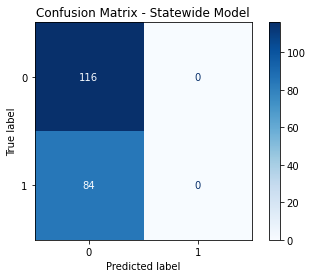

              precision    recall  f1-score   support

       False       0.58      1.00      0.73       116
        True       0.00      0.00      0.00        84

    accuracy                           0.58       200
   macro avg       0.29      0.50      0.37       200
weighted avg       0.34      0.58      0.43       200



c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
gen_report(model, 
[demo_test_df.iloc[:,:-3].values.astype(np.float32), test_images_pross.astype(np.float32)],
demo_test_df['label'].values,
'Confusion Matrix - Statewide Model'
)

In [ ]:
# same results!